## CRISP-DM Process Overview

![CRISP-DM Process Overview](crispdm.png)

### 1. [Business Understanding](#business-understanding)
___
<a id="business-understanding"></a>
## Business Understanding

The goal is to understand the influence of demographic factors and offer types on the amount a user spends. Both offer details and user demographics play a crucial role in determining user behavior and their interaction with offers.

### 2. [Data Understanding](#data-understanding)
___
<a id="data-understanding"></a>
## Data Understanding

The goal is to understand and clean up the initial data: `portfolio`,`profile` and `transcript`. 
- The `portfolio` dataset provides details about different offers, such as the type, duration, and channels used.
- The `profile` dataset offers demographic information about users.
- The `transcript` dataset captures the interactions of users with offers, including receiving, viewing, completing offers, and making transactions.

Great! We've successfully loaded the data into three pandas DataFrames: `portfolio`, `profile`, and `transcript`. Let's delve deeper into the data to understand its structure and characteristics.

#### 1. Portfolio

The `portfolio` DataFrame provides details about different offers.

Columns:
- **reward**: Reward amount given for completing the offer.
- **channels**: List of channels through which the offer was sent.
- **difficulty**: Minimum spending required to complete the offer.
- **duration**: Duration for which the offer is valid (in days).
- **offer_type**: Type of the offer (e.g., BOGO, discount, informational).
- **id**: Unique identifier for the offer.

#### 2. Profile

The `profile` DataFrame contains demographic data for each user.

Columns:
- **gender**: Gender of the user (M, F, O, or None).
- **age**: Age of the user.
- **id**: Unique identifier for the user.
- **became_member_on**: Date when the user became a member.
- **income**: User's income.

#### 3. Transcript

The `transcript` DataFrame captures event data related to offers and transactions.

Columns:
- **person**: Unique identifier for the user.
- **event**: Type of event (e.g., offer received, offer viewed, transaction).
- **value**: Dictionary containing offer id or transaction amount.
- **time**: Time when the event occurred (measured in hours since the start of the test).

#### Observations:
- In the `profile` DataFrame, some users have an age of 118, which seems to be a placeholder for missing values.
- Gender and income have missing values in the `profile` DataFrame.
- The `transcript` DataFrame's `value` column contains dictionaries that either provide an offer id or transaction amount, depending on the event type.

In [1]:
# Basic libraries for data manipulation and mathematical computations
import pandas as pd
import numpy as np
import math
import json

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Miscellaneous utilities
from typing import List, Dict
from pprint import pprint
import warnings

# Settings and configurations
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("muted")
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10, 6)
%matplotlib inline


In [2]:
# read in the json files
portfolio = pd.read_json('Data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('Data/profile.json', orient='records', lines=True)
transcript = pd.read_json('Data/transcript.json', orient='records', lines=True)

In [3]:
portfolio_info = {
"Number of Rows": len(portfolio),
"Number of Columns": len(portfolio.columns),
"Column Names": portfolio.columns.tolist(),
"Missing Values": portfolio.isnull().sum().to_dict(),
"Data Types": portfolio.dtypes.to_dict()
}

print("Portfolio Info:")
pprint(portfolio_info)

portfolio_description = portfolio.describe()
print("\nPortfolio Description:")
pprint(portfolio_description.to_dict())

Portfolio Info:
{'Column Names': ['reward',
                  'channels',
                  'difficulty',
                  'duration',
                  'offer_type',
                  'id'],
 'Data Types': {'channels': dtype('O'),
                'difficulty': dtype('int64'),
                'duration': dtype('int64'),
                'id': dtype('O'),
                'offer_type': dtype('O'),
                'reward': dtype('int64')},
 'Missing Values': {'channels': 0,
                    'difficulty': 0,
                    'duration': 0,
                    'id': 0,
                    'offer_type': 0,
                    'reward': 0},
 'Number of Columns': 6,
 'Number of Rows': 10}

Portfolio Description:
{'difficulty': {'25%': 5.0,
                '50%': 8.5,
                '75%': 10.0,
                'count': 10.0,
                'max': 20.0,
                'mean': 7.7,
                'min': 0.0,
                'std': 5.8319045869347965},
 'duration': {'25%': 5.0,
       

Portfolio Data Overview:
* Shape: The dataset contains 10 rows and 6 columns.
* Columns: The columns present are 'reward', 'channels', 'difficulty', 'duration', 'offer_type', and 'id'.
* Missing Values: There are no missing values in the dataset.

In [4]:
profile_info = {
    "Number of Rows": len(profile),
    "Number of Columns": len(profile.columns),
    "Column Names": profile.columns.tolist(),
    "Missing Values": profile.isnull().sum().to_dict(),
    "Data Types": profile.dtypes.to_dict()
}
profile_description = profile.describe()

Profile Data Overview:

* Shape: The dataset contains 17,000 rows and 5 columns.
* Columns: The columns present are 'gender', 'age', 'id', 'became_member_on', and 'income'.

In [5]:
transcript_info = {
    "Number of Rows": len(transcript),
    "Number of Columns": len(transcript.columns),
    "Column Names": transcript.columns.tolist(),
    "Missing Values": transcript.isnull().sum().to_dict(),
    "Data Types": transcript.dtypes.to_dict()
}
print("Transcript Info:")
pprint(transcript_info)

Transcript Info:
{'Column Names': ['person', 'event', 'value', 'time'],
 'Data Types': {'event': dtype('O'),
                'person': dtype('O'),
                'time': dtype('int64'),
                'value': dtype('O')},
 'Missing Values': {'event': 0, 'person': 0, 'time': 0, 'value': 0},
 'Number of Columns': 4,
 'Number of Rows': 306534}


Transcript Data Overview:

* Shape: The dataset contains 306,534 rows and 4 columns.
* Columns: The columns present are 'person', 'event', 'value', and 'time'.
* Missing Values: There are no missing values in this dataset.

In [6]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.00
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.00
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


#### Data Visualization

Visualizing the datasets can provide a wealth of information at a glance. This section is dedicated to unearthing patterns, distributions, and relationships within the `profile`, `transcript`, and `portfolio` datasets.


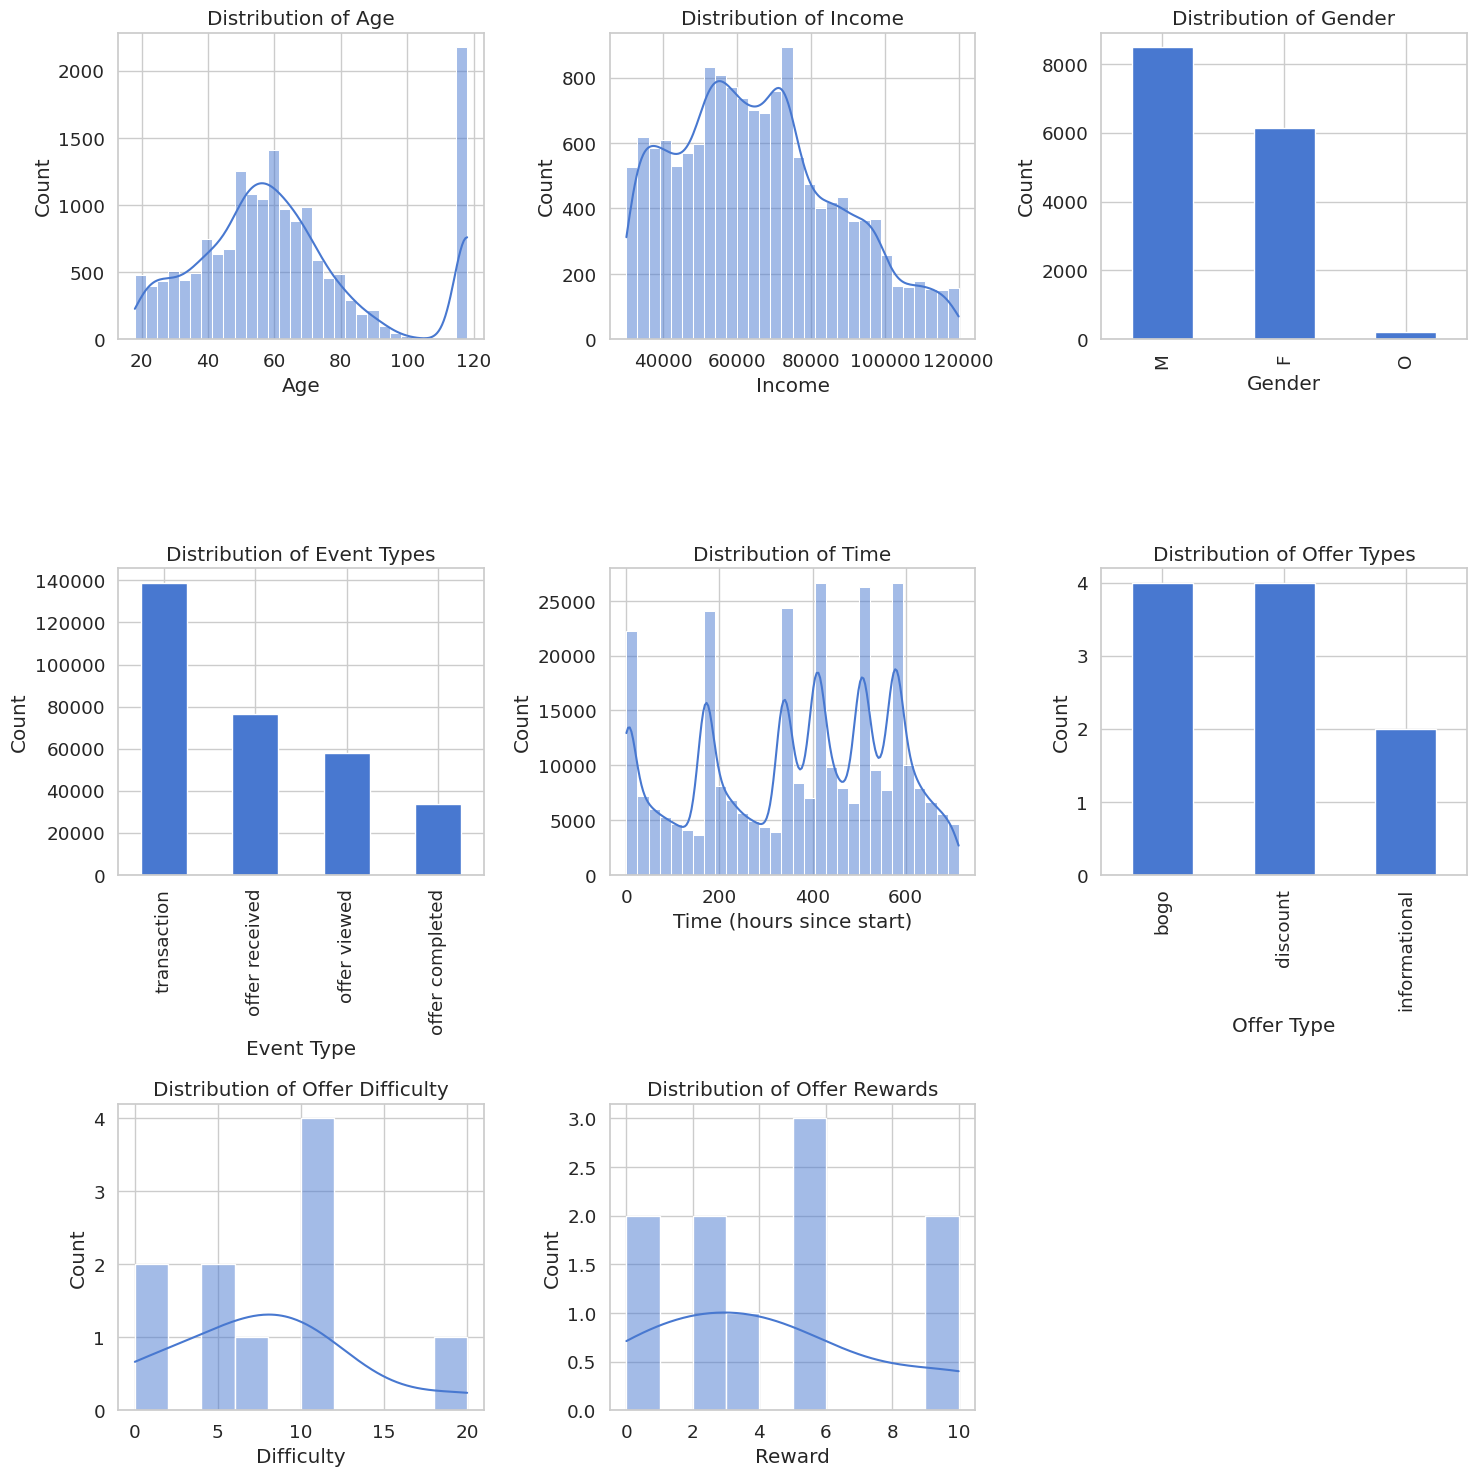

In [9]:
plt.figure(figsize=(15, 15))

# Visualization for Profile Data
# --------------------------------

# Age Distribution
plt.subplot(3, 3, 1)
sns.histplot(profile['age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')

# Income Distribution
plt.subplot(3, 3, 2)
sns.histplot(profile[profile['income'].notnull()]['income'], bins=30, kde=True)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Count')

# Gender Distribution
plt.subplot(3, 3, 3)
profile['gender'].value_counts().plot(kind='bar')
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

# Visualization for Transcript Data
# ---------------------------------

# Event Types Distribution
plt.subplot(3, 3, 4)
transcript['event'].value_counts().plot(kind='bar')
plt.title('Distribution of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Count')

# Time Distribution
plt.subplot(3, 3, 5)
sns.histplot(transcript['time'], bins=30, kde=True)
plt.title('Distribution of Time')
plt.xlabel('Time (hours since start)')
plt.ylabel('Count')

# Visualization for Portfolio Data
# --------------------------------

# Offer Types Distribution
plt.subplot(3, 3, 6)
portfolio['offer_type'].value_counts().plot(kind='bar')
plt.title('Distribution of Offer Types')
plt.xlabel('Offer Type')
plt.ylabel('Count')

# Offer Difficulty Distribution
plt.subplot(3, 3, 7)
sns.histplot(portfolio['difficulty'], bins=10, kde=True)
plt.title('Distribution of Offer Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Count')

# Offer Rewards Distribution
plt.subplot(3, 3, 8)
sns.histplot(portfolio['reward'], bins=10, kde=True)
plt.title('Distribution of Offer Rewards')
plt.xlabel('Reward')
plt.ylabel('Count')

# Adjust the plots for better layout
plt.tight_layout()
plt.show()


### Insights from Data Visualization

Data visualization is a powerful tool in a data scientist's arsenal. It allows us to quickly and intuitively understand the underlying patterns and distributions in our data. Let's distill the key insights from our visual explorations:

1. **Profile Data Insights**:
   - **Age Distribution**: 
     - The majority of Starbucks app users fall in the age bracket of 40 to 70.
     - An anomalous spike is observed around the age of 118, which seems to be a placeholder for missing or unreported data. This requires further investigation.
   - **Income Distribution**:
     - The income graph showcases multimodal peaks. A significant portion of users have an income range of 50k-75k.
     - Notable spikes are also evident around the 30k and 100k marks, possibly indicating different demographic clusters.
   - **Gender Distribution**: 
     - More males than females are represented in the app user data. 
     - A smaller segment identifies with other genders or didn't specify their gender.

2. **Transcript Data Insights**:
   - **Event Type Distribution**:
     - Transactions are the most prevalent event type, indicating a high rate of purchase activities on the app.
     - Offers received come next, highlighting Starbucks' proactive approach in reaching out with deals and offers.
   - **Time Distribution**:
     - The distribution of the time variable unveils periods of heightened activity or offer interactions, represented by the pronounced peaks.

3. **Portfolio Data Insights**:
   - **Offer Type Distribution**: 
     - BOGO (Buy One Get One) and discount offers dominate the distribution, indicating Starbucks' inclination towards these promotional strategies.
     - Informational offers, while present, are rarer in comparison.
   - **Offer Difficulty Distribution**:
     - Offers are primarily clustered around difficulty levels of 5, 10, and 20 units, suggesting these are standard thresholds set by Starbucks for offer redemptions.
   - **Reward Distribution**:
     - Rewards are largely distributed at 2, 5, and 10 units.
     - A minor segment of offers provides no rewards, likely corresponding to informational offers.

These insights lay the foundation for our upcoming data preparation and modeling phases, guiding our decisions and strategies.


### 3. [Data Preparation](#3-data-preparation)
___
<a id="Data Preparation"></a>
## Data Preparation

**Objective**: Refine and transform the raw data to make it model-ready.


**Insights**:
- Data cleaning is the bedrock of any data science project. Addressing anomalies, like the age value of 118, and imputing missing values can significantly enhance model performance.
- Beyond cleaning, feature engineering can unlock deeper insights. For instance, transforming the `became_member_on` feature to compute a `membership_duration` can provide more actionable insights than a mere start date.
- Categorical features like `gender` and `event` need encoding to make them suitable for machine learning algorithms.

**Tasks**:
- **Anomaly Treatment**: Address identified anomalies in the dataset.
- **Feature Engineering**: Derive new features from existing ones to capture richer information. Examples include computing membership duration from `became_member_on`.
- **Categorical Encoding**: Convert categorical features into a format suitable for machine learning algorithms.
- **Data Integration**: Merge datasets if required to provide a comprehensive view for modeling.


In [10]:
def clean_portfolio(portfolio: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the portfolio dataset.
    
    This function processes the portfolio dataset by creating one-hot encoded columns for the channels
    and renaming the 'id' column to 'offer_id'. The function also includes error handling for multiple 
    runs and reorders columns for better readability.
    
    Args:
    - portfolio (pd.DataFrame): Original portfolio dataset with columns ['id', 'offer_type', 'reward', 'channels',
      'difficulty', 'duration'].
      
    Returns:
    - pd.DataFrame: Cleaned portfolio dataset with one-hot encoded channels and 'offer_id' as the identifier.
    """
    
    # Ensure function doesn't fail if run multiple times
    if 'channels' in portfolio.columns:
        # Create dummy columns for the channels column
        d_chann = portfolio['channels'].explode().reset_index()
        d_chann = pd.get_dummies(d_chann, columns=['channels'], prefix="channel").groupby('index').sum()

        # Concatenate dummy columns and drop original 'channels' column
        portfolio = pd.concat([portfolio, d_chann], axis=1).drop(columns='channels')
    
    # Rename 'id' column to 'offer_id' if it exists
    if 'id' in portfolio.columns:
        portfolio.rename(columns={'id':'offer_id'}, inplace=True)

    # Reorder columns for better readability
    ordered_columns = ['offer_id', 'offer_type', 'reward', 'difficulty', 'duration', 
                       'channel_email', 'channel_mobile', 'channel_social', 'channel_web']
    
    portfolio = portfolio[ordered_columns]

    return portfolio

In [11]:
portfolio = clean_portfolio(portfolio)
portfolio.head()

,offer_id,offer_type,reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,1,1,1,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,1,1,1,1
2,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,1,1,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,1,1,0,1
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,20,10,1,0,0,1


In [12]:
def clean_profile(profile: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the profile dataset.
    
    This function processes the profile dataset by:
    - Converting the 'became_member_on' column to datetime format.
    - Adding a 'valid' column to identify customers with valid demographic data.
    - Renaming the 'id' column to 'customer_id'.
    - One-hot encoding the 'gender' column.
    - Handling missing data.
    
    Args:
    profile (pd.DataFrame): Original profile dataset with columns ['id', 'gender', 'age', 'became_member_on', 'income'].
    
    Returns:
    pd.DataFrame: Cleaned profile dataset with added 'valid' and one-hot encoded 'gender' columns, and 'customer_id' as identifier.
    """
    
    profile_clean = profile.copy()
    
    # Convert 'became_member_on' column to datetime format if not already
    if profile_clean['became_member_on'].dtype != 'datetime64[ns]':
        profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'].astype(str), format='%Y%m%d')
    
    # Add 'valid' column to identify customers with valid demographic data if not already added
    if 'valid' not in profile_clean.columns:
        profile_clean['valid'] = ((profile_clean['age'] != 118) & 
                                  profile_clean['gender'].notnull() & 
                                  profile_clean['income'].notnull()).astype(int)
    
    # Rename 'id' column to 'customer_id' if present
    if 'id' in profile_clean.columns:
        profile_clean.rename(columns={'id': 'customer_id'}, inplace=True)
    
    # One-hot encode the 'gender' column if not already done
    if 'gender_M' not in profile_clean.columns:
        dummy_gender = pd.get_dummies(profile_clean['gender'], prefix="gender")
        profile_clean = pd.concat([profile_clean, dummy_gender], axis=1)
        profile_clean.drop(columns='gender', inplace=True)
    
    return profile_clean

In [13]:
# Testing the updated function
profile = clean_profile(profile)
profile.head()

,age,customer_id,became_member_on,income,valid,gender_F,gender_M,gender_O
0,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,0,False,False,False
1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.00,1,True,False,False
2,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,0,False,False,False
3,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.00,1,True,False,False
4,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,0,False,False,False


In [14]:
def clean_transcript(transcript: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the transcript dataset.
    
    This function processes the transcript dataset by:
    - Creating one-hot encoded columns for the 'event' column.
    - Extracting 'offer_id' and 'amount' details from the 'value' column.
    - Renaming the 'person' column to 'customer_id'.
    
    Args:
    transcript (pd.DataFrame): Original transcript dataset with columns ['person', 'event', 'value', 'time'].
    
    Returns:
    pd.DataFrame: Cleaned transcript dataset with one-hot encoded 'event' columns, extracted 'offer_id' and 'amount', and 'customer_id' as identifier.
    """
    
    transcript_clean = transcript.copy()
    
    # Convert the 'event' column values to snake_case and create one-hot encoded columns if not done already
    if 'event' in transcript_clean.columns:
        transcript_clean['event'] = transcript_clean['event'].str.replace(' ', '_')
        dummy_event = pd.get_dummies(transcript_clean['event'], prefix="event")
        transcript_clean = pd.concat([transcript_clean, dummy_event], axis=1)
        transcript_clean.drop(columns='event', inplace=True)
    
    # Extract 'offer_id' from the 'value' column if not done already
    if 'offer_id' not in transcript_clean.columns:
        transcript_clean['offer_id'] = [v.get('offer id') or v.get('offer_id') for v in transcript_clean['value']]
    
    # Extract 'amount' from the 'value' column and round to 2 decimal places if not done already
    if 'amount' not in transcript_clean.columns:
        transcript_clean['amount'] = [np.round(v.get('amount', 0), decimals=2) for v in transcript_clean['value']]
    
    # Drop the 'value' column if it exists
    if 'value' in transcript_clean.columns:
        transcript_clean.drop(columns='value', inplace=True)
    
    # Rename 'person' column to 'customer_id' if it exists
    if 'person' in transcript_clean.columns:
        transcript_clean.rename(columns={'person': 'customer_id'}, inplace=True)
    
    return transcript_clean

In [15]:
# Testing the updated function
transcript = clean_transcript(transcript)
transcript.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,False,True,False,False,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
1,a03223e636434f42ac4c3df47e8bac43,0,False,True,False,False,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.00
2,e2127556f4f64592b11af22de27a7932,0,False,True,False,False,2906b810c7d4411798c6938adc9daaa5,0.00
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,False,True,False,False,fafdcd668e3743c1bb461111dcafc2a4,0.00
4,68617ca6246f4fbc85e91a2a49552598,0,False,True,False,False,4d5c57ea9a6940dd891ad53e9dbe8da0,0.00


In [16]:
def merge_datasets(portfolio_clean: pd.DataFrame, profile_clean: pd.DataFrame, transcript_clean: pd.DataFrame) -> pd.DataFrame:
    """
    Merge the cleaned portfolio, profile, and transcript datasets.
    
    This function merges the three cleaned datasets into a single consolidated dataset.
    It also simplifies the offer_ids for easier reference.
    
    Args:
    portfolio_clean (pd.DataFrame): Cleaned portfolio dataset.
    profile_clean (pd.DataFrame): Cleaned profile dataset.
    transcript_clean (pd.DataFrame): Cleaned transcript dataset.
    
    Returns:
    pd.DataFrame: Merged dataset with simplified offer_ids.
    """
    
    # Merge transcript_clean and profile_clean on 'customer_id'
    trans_prof = pd.merge(transcript_clean, profile_clean, on='customer_id', how="left")
    
    # Merge trans_prof with portfolio_clean on 'offer_id'
    df = pd.merge(trans_prof, portfolio_clean, on='offer_id', how='left')
    
    # Simplify the offer_ids for easier reference
    offer_id_mapping = {
        'ae264e3637204a6fb9bb56bc8210ddfd': 'B1',
        '4d5c57ea9a6940dd891ad53e9dbe8da0': 'B2',
        '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'B3',
        'f19421c1d4aa40978ebb69ca19b0e20d': 'B4',
        '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'D1',
        '2298d6c36e964ae4a3e7e9706d1fb8c2': 'D2',
        'fafdcd668e3743c1bb461111dcafc2a4': 'D3',
        '2906b810c7d4411798c6938adc9daaa5': 'D4',
        '3f207df678b143eea3cee63160fa8bed': 'I1',
        '5a8bc65990b245e5a138643cd4eb9837': 'I2'
    }
    
    df['offer_id'] = df['offer_id'].map(offer_id_mapping).fillna(df['offer_id'])
    
    return df

In [17]:
df = merge_datasets(portfolio, profile, transcript)
merged_df = df.copy()
df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,age,became_member_on,...,gender_M,gender_O,offer_type,reward,difficulty,duration,channel_email,channel_mobile,channel_social,channel_web
0,78afa995795e4d85b5d9ceeca43f5fef,0,False,True,False,False,B3,0.00,75,2017-05-09,...,False,False,bogo,5.00,5.00,7.00,1.00,1.00,0.00,1.00
1,a03223e636434f42ac4c3df47e8bac43,0,False,True,False,False,D1,0.00,118,2017-08-04,...,False,False,discount,5.00,20.00,10.00,1.00,0.00,0.00,1.00
2,e2127556f4f64592b11af22de27a7932,0,False,True,False,False,D4,0.00,68,2018-04-26,...,True,False,discount,2.00,10.00,7.00,1.00,1.00,0.00,1.00
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,False,True,False,False,D3,0.00,118,2017-09-25,...,False,False,discount,2.00,10.00,10.00,1.00,1.00,1.00,1.00
4,68617ca6246f4fbc85e91a2a49552598,0,False,True,False,False,B2,0.00,118,2017-10-02,...,False,False,bogo,10.00,10.00,5.00,1.00,1.00,1.00,1.00


In [18]:
df.describe()
print()
# Checking the completeness of labels (missing values) in the dataframe
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / df.shape[0]) * 100

# Combining the results into a dataframe
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

missing_data.sort_values(by='Percentage', ascending=False)

,Missing Values,Percentage
channel_web,138953,45.33
channel_social,138953,45.33
channel_mobile,138953,45.33
channel_email,138953,45.33
duration,138953,45.33
offer_id,138953,45.33
difficulty,138953,45.33
reward,138953,45.33
offer_type,138953,45.33
income,33772,11.02


This code focuses on handling the missing values in the `income` column and then categorizing the income into different groups.
```markdown
### Handling Missing Values in Income

The `income` column has some missing values. A common and robust method to handle missing values for a continuous variable is to replace them with the median of the column. The median is less sensitive to extreme values (outliers) than the mean. In this analysis, the missing values in the `income` column are replaced with its median.

```python
# Filling up the missing values in 'income' column with the median
income_median = df['income'].median()
df['income'].fillna(income_median, inplace=True)
```

### Categorizing Income

From the initial data exploration, it was observed that the income distribution is bimodal. To simplify the analysis and modeling, the continuous `income` column is converted into categorical groups. The income is categorized into three groups:

- **Low**: Income less than or equal to 40,000
- **Average**: Income between 40,000 and 80,000
- **High**: Income greater than 80,000

```python
# Function to categorize income based on the observed bimodal distribution
def categorize_income(income):
    if income <= 40000:
        return 'low'
    elif 40000 < income <= 80000:
        return 'average'
    else:
        return 'high'

# Apply the function to create the 'income_cat' column
df['income_cat'] = df['income'].apply(categorize_income)
```

Let's check the distribution of the new `income_cat` column:

```python
df['income_cat'].value_counts()
```

This categorization can provide insights into the distribution of income categories in the dataset and can be particularly useful when analyzing how different income groups respond to offers.

<Axes: xlabel='income_cat'>

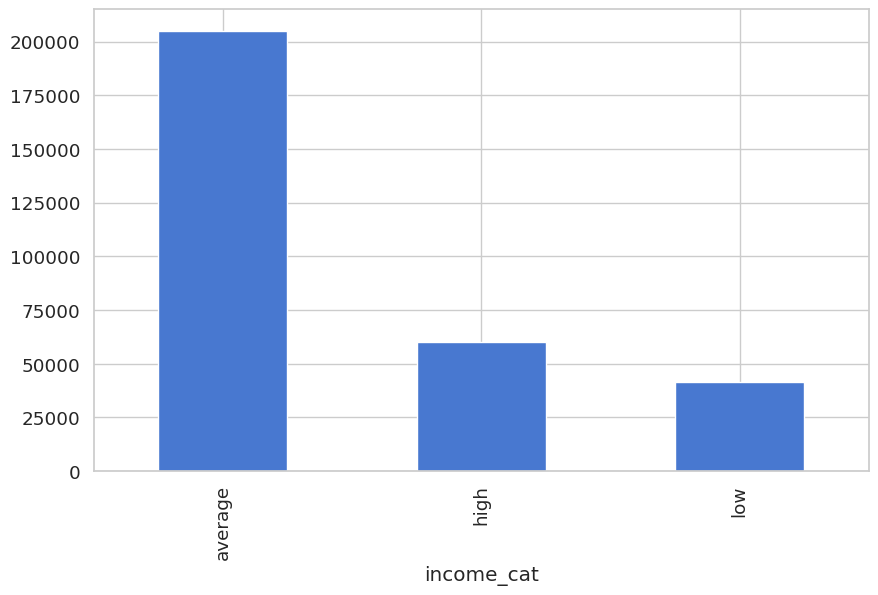

In [21]:
# Filling up the missing values in 'income' column with the median
income_median = df['income'].median()
df['income'].fillna(income_median, inplace=True)
# Function to categorize income based on the observed bimodal distribution
def categorize_income(income):
    if income <= 40000:
        return 'low'
    elif 40000 < income <= 80000:
        return 'average'
    else:
        return 'high'

# Apply the function to create the 'income_cat' column
df['income_cat'] = df['income'].apply(categorize_income)
df['income_cat'].value_counts().plot(kind="bar")

1. **Importing Libraries**:
    The necessary libraries for data manipulation, visualization, and modeling were imported. This step ensures that the tools needed for subsequent stages of the analysis are available.

2. **Loading Data**:
    Three datasets, namely `portfolio`, `profile`, and `transcript`, were read into pandas DataFrames. These datasets hold information about offers, customer demographics, and transactional records, respectively.

3. **Initial Data Exploration**:
    Visualizations were created to understand the distribution of variables like age, income, gender, offer types, and events. 
    - A significant anomaly in age was observed, where a placeholder value of 118 was used for missing ages.
    - The income distribution was bimodal, suggesting two dominant income groups among customers.
    - Gender distribution showed more males than females in the dataset.
    - Most common event type was transactions, followed by offers received.
    
4. **Cleaning Functions**:
    - **Portfolio Data**: The channels were one-hot encoded, and the offer IDs were renamed for clarity.
    - **Profile Data**: 
        - The 'became_member_on' column was converted to a more usable datetime format.
        - Missing and anomalous age values were flagged.
        - Gender was one-hot encoded.
        - A new column indicating the validity of the demographic data for each customer was added.
    - **Transcript Data**: 
        - Events were one-hot encoded.
        - Information like offer_id and transaction amounts were extracted from the 'value' column.
        - The 'person' column was renamed to 'customer_id' for clarity and consistency.

5. **Data Merging**:
    The cleaned versions of the three datasets were merged into a single consolidated DataFrame. This merged DataFrame provides a comprehensive view, linking offers, customer demographics, and transactional records.

6. **Handling Missing Values**:
    - Missing values in the `income` column were imputed using the median, a robust measure against outliers.
  
7. **Feature Engineering**:
    The `income` column was transformed from a continuous to a categorical variable. This transformation was based on the bimodal distribution observed during data exploration:
    - **Low Income**: ≤ $40,000
    - **Average Income**: > $40,000 and ≤ $80,000
    - **High Income**: > $80,000

    The creation of this new categorical variable can aid in understanding how different income groups interact with offers and make purchases.

### Key Insights:

- The presence of placeholder values (like age = 118) indicates the need for careful data cleaning and validation.
- The bimodal distribution of income suggests two dominant groups of Starbucks app users, potentially reflecting different economic classes or life stages.
- Merging datasets provides a holistic view, enabling more complex analyses linking customer attributes, offer details, and transaction behaviors.

In the data preparation phase, the data was transformed into a format suitable for in-depth analyses and modeling, setting the stage for the next steps in the data science process.

### 4. [Modeling and Evaluation](#4-modeling-and-evaluation)
___
<a id="Modeling and Evaluation"></a>
## Modeling and Evaluation

**Objective**: Building a machine learning model that predicts how much someone will spend based on demographics and offer type — the target variable will be `amount`, representing the amount of money a customer spends.

The other variables, such as demographics (`age`, `gender`, `income`) and `offer_type`, will serve as features to help predict this target.


**Insights**:
- Predictive modeling will help in forecasting user spending based on various features. Different models, from linear regression to tree-based algorithms, can be employed.
- Model performance can be gauged using metrics like RMSE (Root Mean Squared Error). A lower RMSE indicates better model performance.
- Feature importance can offer a lens into which features predominantly influence the model's predictions. This can provide actionable business insights.

**Tasks**:
- **Model Construction**: Employ various algorithms to construct predictive models.
- **Model Evaluation**: Evaluate each model's performance using suitable metrics, like RMSE.
- **Feature Importance Analysis**: For tree-based models, analyze feature importance to understand the key predictors.


To help understanding the behavior of the customer and aid in find the answers for the Business Question, lets create a dataframe with customer data.

In [22]:
def customer_data(df):
    """
    Build a dataframe with aggregated offer and transaction data on a customer basis.
    
    Input:
    - df: merged dataframe with transactions, customer, and offer data
    
    Output:
    - customer: dataframe with aggregated data
    """
    
    cust_dict = dict()
    
    # Get total transaction data
    transactions = df[df.event_transaction == 1].groupby('customer_id')
    cust_dict['total_expense'] = transactions.amount.sum()
    cust_dict['total_transactions'] = transactions.amount.count()
    
    # Get aggregated offer data
    for e in ['received', 'viewed', 'completed']:
        flag = (df['event_offer_{}'.format(e)] == 1)
        key = e
        cust_dict[key] = df[flag].groupby('customer_id').offer_id.count()

    # Get reward data
    flag = (df.event_offer_completed == 1)
    cust_dict['reward'] = df[flag].groupby('customer_id').reward.sum()
    
    customers = pd.concat(cust_dict.values(), axis=1, sort=False)
    customers.columns = cust_dict.keys()
    customers.fillna(0, inplace=True)
    
    # Calculate average transaction value
    customers['avg_transaction'] = customers['total_expense'] / customers['total_transactions']
    customers['avg_transaction'].fillna(0, inplace=True)
    
    # Add demographic data
    demographic_cols = ['age', 'income', 'became_member_on', 'gender_F', 'gender_M', 'gender_O']
    customers = pd.merge(customers, df.groupby('customer_id').first()[demographic_cols], left_index=True, right_index=True)
    
    return customers

# Creating the adjusted aggregated dataframe
customer= customer_data(df)
customer.head()

,total_expense,total_transactions,received,viewed,completed,reward,avg_transaction,age,income,became_member_on,gender_F,gender_M,gender_O
customer_id,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8.00,5.00,4.00,3.00,9.00,15.95,33,72000.00,2017-04-21,False,True,False
00116118485d4dfda04fdbaba9a87b5c,4.09,3.00,2.00,2.00,0.00,0.00,1.36,118,62000.00,2018-04-25,False,False,False
0011e0d4e6b944f998e987f904e8c1e5,79.46,5.00,5.00,5.00,3.00,13.00,15.89,40,57000.00,2018-01-09,False,False,True
0020c2b971eb4e9188eac86d93036a77,196.86,8.00,5.00,3.00,3.00,14.00,24.61,59,90000.00,2016-03-04,True,False,False
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12.00,4.00,4.00,3.00,13.00,12.84,24,60000.00,2016-11-11,True,False,False


The function `customer_data` is designed to aggregate user behavior and transaction data to provide a more holistic view of each customer. Here's a breakdown of the function and its significance:

---

### Function Overview - `customer_data`

This function aggregates transactional and offer interaction data for each customer and outputs a dataframe where each row corresponds to a unique customer and the columns represent various aggregated metrics.

#### Steps:

1. **Total Transaction Data**: 
   - It calculates the total amount spent (`total_expense`) by each customer.
   - It counts the total number of transactions (`total_transactions`) made by each customer.

2. **Aggregated Offer Data**:
   - For each event type (`received`, `viewed`, `completed`), it counts the number of occurrences per customer. This gives a perspective on how often a customer interacts with offers.

3. **Reward Data**:
   - Calculates the total rewards earned by a customer for completing offers.

4. **Average Transaction Value**:
   - Computes the average transaction value for each customer as the ratio of `total_expense` to `total_transactions`.

5. **Demographic Data**:
   - Appends demographic details (`age`, `income`, `became_member_on`, and `gender`) for each customer to the aggregated metrics.

#### Output:

The function outputs a dataframe where:
- **Rows**: Unique customers.
- **Columns**: Aggregated metrics like total expense, total transactions, average transaction value, and demographic details.

---

### Insights and Significance:

1. **Understanding Customer Behavior**: With this aggregated view, it becomes easier to understand the behavior and preferences of individual customers. How often do they transact? How do they interact with offers? What's the average value of their transactions?
  
2. **Segmentation and Personalization**: Such aggregated data is pivotal for customer segmentation. By clustering similar behavior customers, businesses can tailor personalized offers or marketing strategies.
   
3. **Demographic Insights**: Combining transactional behavior with demographic data can provide insights into patterns among different demographic groups. For instance, do older customers transact more frequently? Do high-income individuals complete more offers?

4. **Modeling and Predictive Analysis**: This data structure is ideal for building predictive models. If the aim is to predict future spending or the likelihood of a customer completing an offer, this aggregated view serves as an excellent starting point.


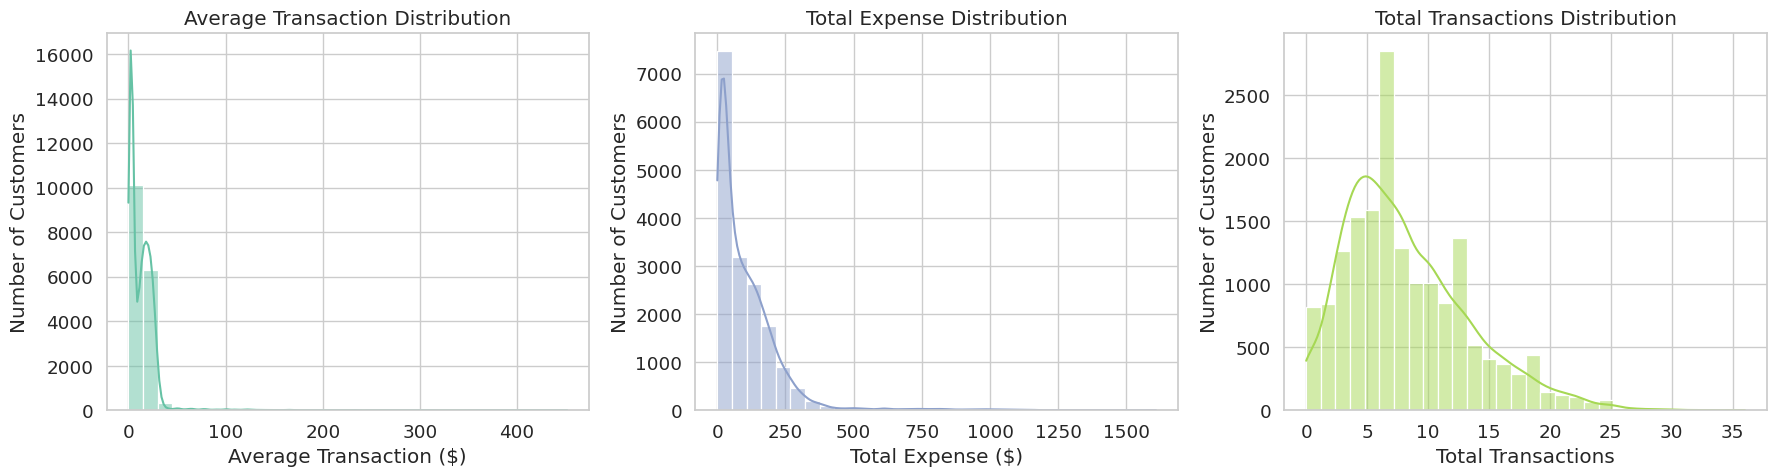

In [23]:
# Define a color palette
palette = sns.color_palette("Set2", 10)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot for avg_transaction
sns.histplot(customer['avg_transaction'], bins=30, kde=True, ax=axes[0], color=palette[0])
axes[0].set_title('Average Transaction Distribution')
axes[0].set_xlabel('Average Transaction ($)')
axes[0].set_ylabel('Number of Customers')

# Plot for total_expense
sns.histplot(customer['total_expense'], bins=30, kde=True, ax=axes[1], color=palette[2])
axes[1].set_title('Total Expense Distribution')
axes[1].set_xlabel('Total Expense ($)')
axes[1].set_ylabel('Number of Customers')

# Plot for total_transactions
sns.histplot(customer['total_transactions'], bins=30, kde=True, ax=axes[2], color=palette[4])
axes[2].set_title('Total Transactions Distribution')
axes[2].set_xlabel('Total Transactions')
axes[2].set_ylabel('Number of Customers')

plt.tight_layout()
plt.show()

From the visualizations, we can draw several important insights about the customer transaction behavior:

1. **Average Transaction Distribution**:
   - The majority of customers tend to have average transactions in the range of roughly $0 to $30.
   - A peak is noticeable around the $10-$15 range, suggesting that many customers spend this amount on average per transaction.
   - There are fewer customers with very high average transaction values, making the distribution right-skewed. This indicates that while most transactions are of moderate value, there are still a number of high-value transactions, but they are less frequent.

2. **Total Expense Distribution**:
   - The majority of customers have total expenses ranging from $0 to roughly $150.
   - There's a significant spike near the beginning of the distribution, indicating a substantial number of customers with low total spending.
   - As with the average transaction distribution, the total expense distribution is also right-skewed. This shows that while many customers have low to moderate total expenses, there is a smaller group of customers who have very high total expenses.

3. **Total Transactions Distribution**:
   - Most customers have made between approximately 0 to 10 transactions.
   - A pronounced peak is evident around 5 transactions, suggesting that a significant number of customers have made around 5 purchases.
   - Fewer customers have made more than 10 transactions, which results in a right-skewed distribution. This indicates that while a majority of the customers have a moderate transaction frequency, there exists a minority who transact very frequently.

**Overall**:
- The data presents a typical behavior seen in many retail settings: a large group of customers make small to moderate purchases or transact infrequently, while a smaller, loyal customer segment makes higher-value purchases or transacts more frequently. Recognizing these patterns can aid in segmenting customers for targeted marketing campaigns. For instance, frequent buyers might be targeted with loyalty programs, while infrequent or low-spending customers might be targeted with special offers to increase their transaction frequency or value.

The columns of interest for demographic data are present with the names:
- `age`
- `became_member_on`
- `income`
- `gender_F`, `gender_M`, and `gender_O` (for gender representation)

To analyze and interpret the demographic data, we'll examine each of the mentioned columns and discuss potential insights:

1. **Age**:
    - This column represents the age of the customers. We can gain insights into which age groups are most prevalent among Starbucks customers, as well as the age distribution.
    - By exploring this column, we can find the average age of a Starbucks customer, the most common age group, and any potential outliers or unusual values.

2. **Became Member On**:
    - This column indicates the date when a customer became a member. This can provide insights into customer acquisition trends over time.
    - By plotting this data, we can determine if there are specific times of the year when more customers tend to join, or if there have been periods of rapid growth or stagnation in membership.

3. **Income**:
    - This column represents the estimated income of customers. This can give insights into the spending power of Starbucks customers.
    - Exploring this data will help in understanding the income distribution of customers, identifying if Starbucks appeals more to a certain income bracket.

4. **Gender (`gender_F`, `gender_M`, `gender_O`)**:
    - These columns represent the gender of customers using one-hot encoding. `gender_F` stands for female, `gender_M` for male, and `gender_O` for other.
    - By analyzing these columns, we can gain insights into the gender distribution among Starbucks customers. This can help in understanding which gender is more prevalent among Starbucks app users and if any specific offers or campaigns are more effective for a particular gender.

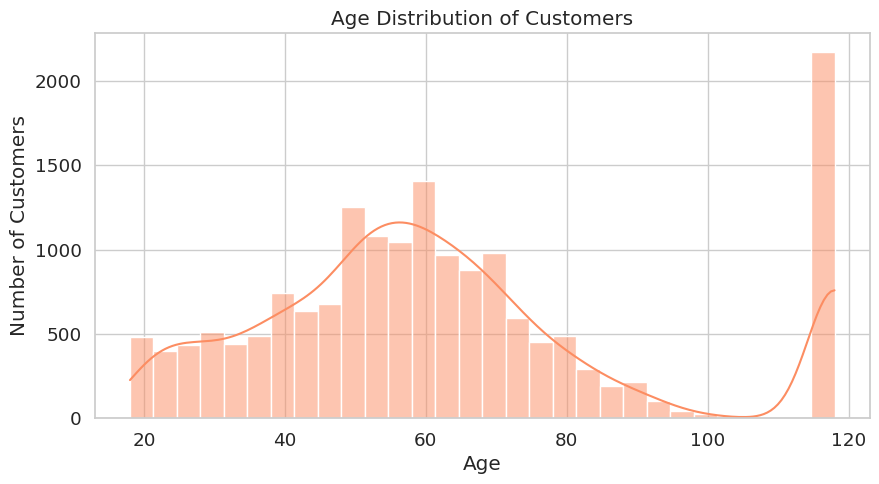

In [24]:
plt.figure(figsize=(10, 5))
sns.histplot(customer['age'], bins=30, kde=True, color=palette[1])
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.show()

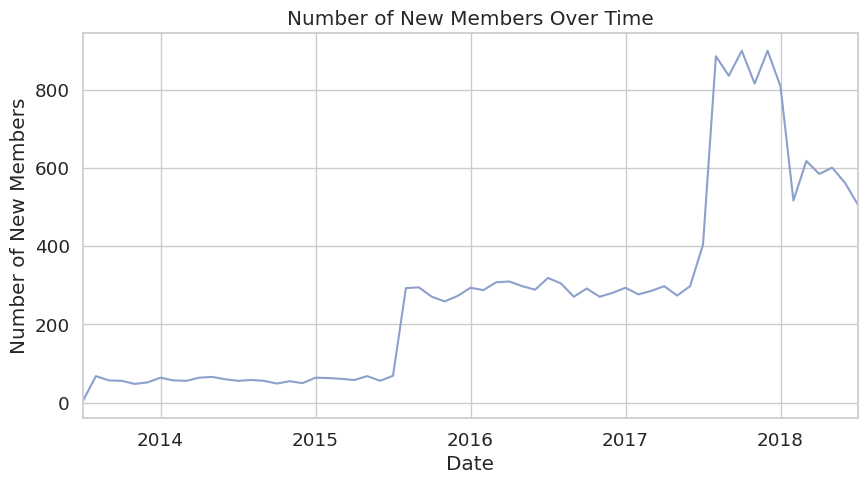

In [25]:
plt.figure(figsize=(10, 5))
customer['became_member_on'].value_counts().resample('M').sum().plot(color=palette[2])
plt.title('Number of New Members Over Time')
plt.xlabel('Date')
plt.ylabel('Number of New Members')
plt.show()

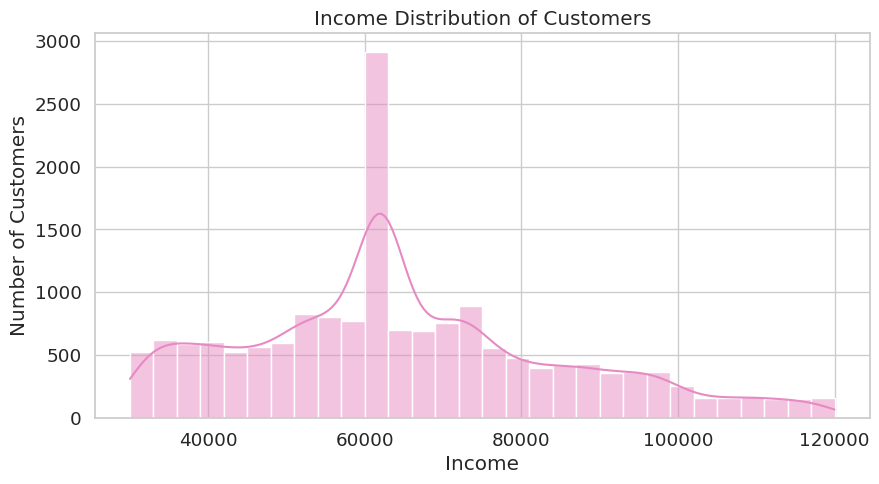

In [26]:
plt.figure(figsize=(10, 5))
sns.histplot(customer['income'], bins=30, kde=True, color=palette[3])
plt.title('Income Distribution of Customers')
plt.xlabel('Income')
plt.ylabel('Number of Customers')
plt.show()

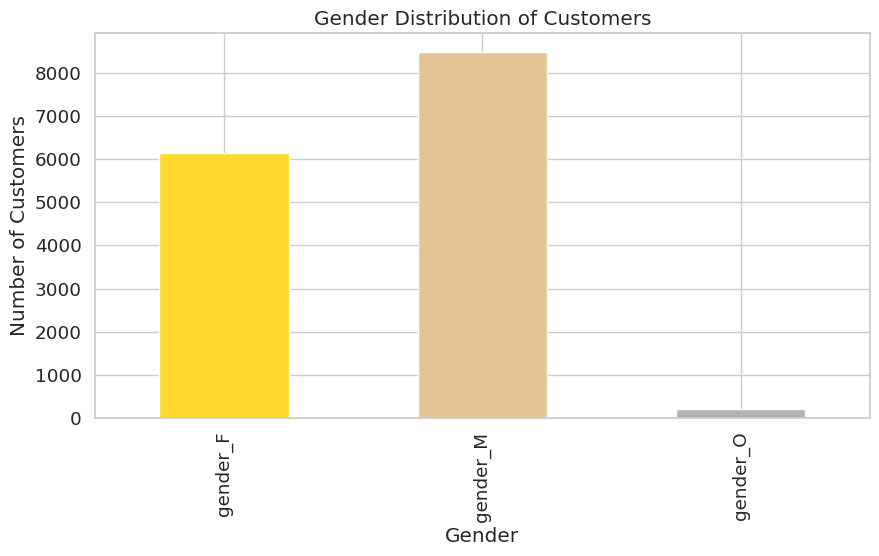

In [28]:
gender_data = customer[['gender_F', 'gender_M', 'gender_O']].sum()
plt.figure(figsize=(10, 5))
gender_data.plot(kind='bar', color=palette[5:8])
plt.title('Gender Distribution of Customers')
plt.xlabel('Gender')
plt.ylabel('Number of Customers')
plt.show()


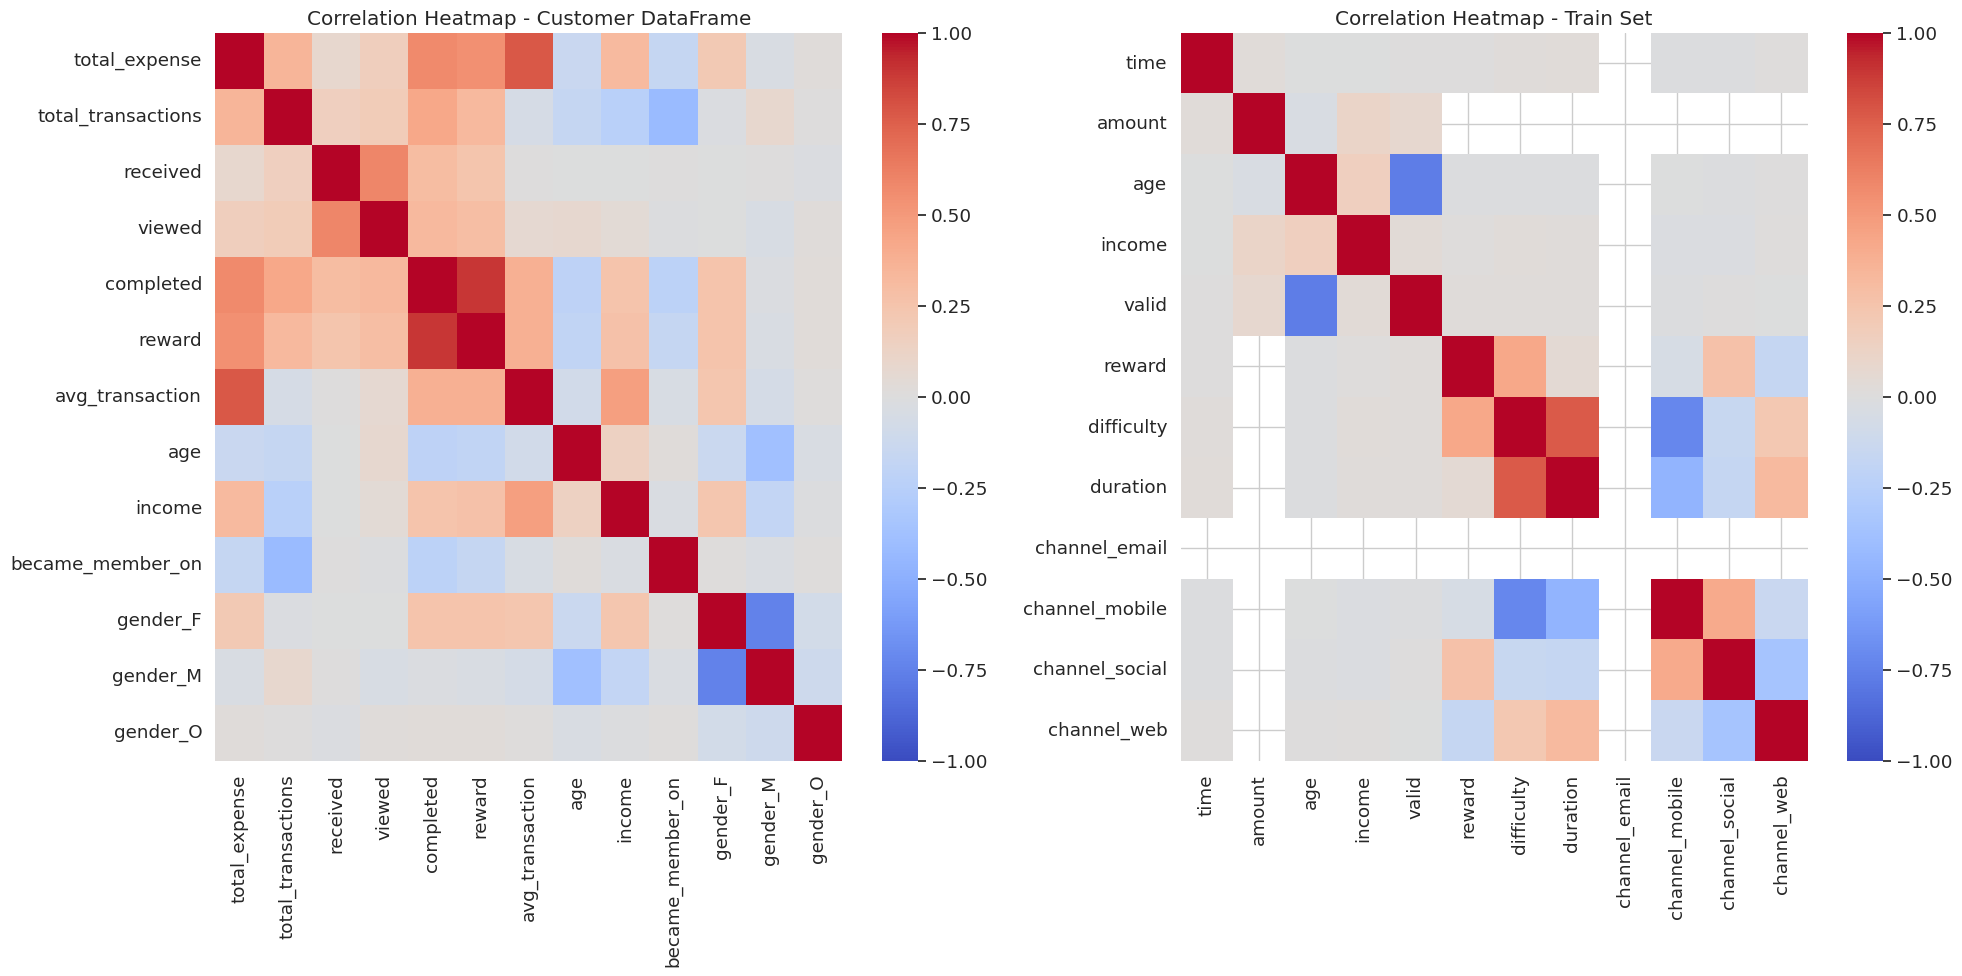

In [29]:
# Calculate correlation for the customer dataframe
customer_corr = customer.corr()

# Calculate correlation for the train_set
numerical_cols = df.select_dtypes(include=[np.number]).columns
df_corr = df[numerical_cols].corr()

# Plotting the correlations
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.heatmap(customer_corr, ax=axes[0], cmap="coolwarm", vmin=-1, vmax=1)
axes[0].set_title("Correlation Heatmap - Customer DataFrame")

sns.heatmap(df_corr, ax=axes[1], cmap="coolwarm", vmin=-1, vmax=1)
axes[1].set_title("Correlation Heatmap - Train Set")
plt.tight_layout()
plt.show()

1. **Amount and Transaction Event**: 
   - As transactions occur, the total amount spent by a customer naturally increases. This direct relationship explains the strong correlation between `amount` and `event_transaction`.

2. **Offer Events**:
   - The fact that the receipt and viewing of an offer don't show significant correlations with other variables reinforces the idea that a customer's initial interaction with an offer doesn't necessarily lead to subsequent behaviors.
   - The positive correlation between `event_offer_completed` and `reward` highlights the design of the offers; completing offers results in rewards.

3. **Demographics**:
   - The differing correlations between `income` with `gender_F` and `gender_M` could be indicative of underlying gender income disparities within the dataset's customer base. This might warrant a more in-depth look, considering broader societal discussions on gender wage gaps.
   - The relative independence of `age` suggests that age, by itself, might not be a significant determinant of offer interactions or spending behaviors, at least when considered outside the context of other variables.

4. **Time and Events**:
   - The correlation between `time` and offer-related events might indicate specific patterns or cycles in how Starbucks sends out offers. This could be linked to marketing strategies or business cycles.

Overall, these correlations provide a bird's-eye view of how different variables relate to one another. Understanding these relationships is crucial not just for predictive modeling but also for deriving actionable business insights. For instance:

- If certain channels (`channel_web`, `channel_email`, etc.) consistently relate to completed offers, it suggests these channels are effective for driving customer engagement.
- If there's a correlation between higher `income` and offer completion, Starbucks might consider tailoring premium offers to higher-income segments.
knowledge would be needed to derive definitive conclusions or strategies.

### Processing the data for modeling

In [30]:
# Processing the data for modeling
# 1. Calculate total_expense and total_transactions
transactions = merged_df[merged_df.event_transaction == True].groupby('customer_id')['amount']
merged_df['total_expense'] = merged_df['customer_id'].map(transactions.sum())
merged_df['total_transactions'] = merged_df['customer_id'].map(transactions.size())

# 2. Calculate the number of each `offer_type` received.
for offer in merged_df['offer_type'].unique():
    event_data = merged_df[merged_df['offer_type'] == offer].groupby('customer_id')
    merged_df[f'offer_{offer}'] = merged_df['customer_id'].map(event_data.size())

# 3. Calculate the total reward from completed offers.
completed_rewards = merged_df[merged_df.event_offer_completed == True].groupby('customer_id')['reward']
merged_df['total_reward'] = merged_df['customer_id'].map(completed_rewards.sum())

# 4. Calculate the average transaction value.
merged_df['avg_transaction'] = merged_df['total_expense'] / merged_df['total_transactions']

merged_df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,age,became_member_on,...,channel_social,channel_web,total_expense,total_transactions,offer_bogo,offer_discount,offer_informational,offer_nan,total_reward,avg_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,False,True,False,False,B3,0.00,75,2017-05-09,...,0.00,1.00,159.27,7.00,9.00,NaN,2.00,NaN,20.00,22.75
1,a03223e636434f42ac4c3df47e8bac43,0,False,True,False,False,D1,0.00,118,2017-08-04,...,0.00,1.00,4.65,3.00,NaN,5.00,3.00,NaN,NaN,1.55
2,e2127556f4f64592b11af22de27a7932,0,False,True,False,False,D4,0.00,68,2018-04-26,...,0.00,1.00,57.73,3.00,3.00,5.00,1.00,NaN,7.00,19.24
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,False,True,False,False,D3,0.00,118,2017-09-25,...,1.00,1.00,NaN,NaN,2.00,6.00,2.00,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,False,True,False,False,B2,0.00,118,2017-10-02,...,1.00,1.00,0.24,2.00,5.00,4.00,NaN,NaN,NaN,0.12


The code above aggregate and compute several new features at the customer level, which can be crucial for modeling. 

1. **Total Expense and Total Transactions**:
    - `total_expense`: This represents the total amount spent by a customer. By aggregating this information, we can get a sense of each customer's value or spending capability.
    - `total_transactions`: This signifies the number of transactions made by a customer, which can indicate the frequency of their interactions with Starbucks.

2. **Offers Received**:
    - This loop creates a new column for each `offer_type` (like BOGO, discount, and informational). The value in each column represents the number of times a customer has received that specific offer type. Understanding how frequently customers receive each offer type can shed light on which offers are most commonly sent out and which customer segments are targeted with specific offers.

3. **Total Reward from Completed Offers**:
    - `total_reward`: This sums up the total rewards a customer has gained from completing offers. A higher value here can indicate a customer's responsiveness to offers. It's a direct measure of the benefit a customer has received from interacting with Starbucks' offers.

4. **Average Transaction Value**:
    - `avg_transaction`: This is the average amount spent by a customer in each transaction. It provides a measure of spending behavior. For instance, some customers might transact frequently but spend less each time, while others might transact less often but spend more in each transaction. This feature captures that nuance.

In [31]:
df = merged_df.copy()
df.isna().sum()
df.shape

(306534, 31)

In [32]:
# Calculate the percentage of missing values for each column
missing_percentage = (missing_values / len(df)) * 100
missing_percentage

customer_id              0.00
time                     0.00
event_offer_completed    0.00
event_offer_received     0.00
event_offer_viewed       0.00
event_transaction        0.00
offer_id                45.33
amount                   0.00
age                      0.00
became_member_on         0.00
income                  11.02
valid                    0.00
gender_F                 0.00
gender_M                 0.00
gender_O                 0.00
offer_type              45.33
reward                  45.33
difficulty              45.33
duration                45.33
channel_email           45.33
channel_mobile          45.33
channel_social          45.33
channel_web             45.33
dtype: float64

In [33]:
# Drop columns with 45.33% missing values
columns_to_drop = missing_percentage[missing_percentage == 45.33].index
df.drop(columns=columns_to_drop, inplace=True)

# Verify the updated dataframe
df.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,age,became_member_on,...,channel_social,channel_web,total_expense,total_transactions,offer_bogo,offer_discount,offer_informational,offer_nan,total_reward,avg_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,False,True,False,False,B3,0.00,75,2017-05-09,...,0.00,1.00,159.27,7.00,9.00,NaN,2.00,NaN,20.00,22.75
1,a03223e636434f42ac4c3df47e8bac43,0,False,True,False,False,D1,0.00,118,2017-08-04,...,0.00,1.00,4.65,3.00,NaN,5.00,3.00,NaN,NaN,1.55
2,e2127556f4f64592b11af22de27a7932,0,False,True,False,False,D4,0.00,68,2018-04-26,...,0.00,1.00,57.73,3.00,3.00,5.00,1.00,NaN,7.00,19.24
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,False,True,False,False,D3,0.00,118,2017-09-25,...,1.00,1.00,NaN,NaN,2.00,6.00,2.00,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,False,True,False,False,B2,0.00,118,2017-10-02,...,1.00,1.00,0.24,2.00,5.00,4.00,NaN,NaN,NaN,0.12


In [34]:
df.amount.describe()

count   306534.00
mean         5.79
std         21.34
min          0.00
25%          0.00
50%          0.00
75%          7.10
max       1062.28
Name: amount, dtype: float64

In [35]:
df = df.drop(columns = 'time')

In [36]:
# Selecting the relevant features and the target variable
selected_features = [
    'age', 'income', 'gender_F', 'gender_M', 'gender_O', 
    'offer_bogo', 'offer_discount', 'offer_informational',
    'became_member_on', 'offer_type', 'total_expense', 
    'total_transactions', 'amount'
]

df= df[selected_features]
df.head()

,age,income,gender_F,gender_M,gender_O,offer_bogo,offer_discount,offer_informational,became_member_on,offer_type,total_expense,total_transactions,amount
0,75,100000.00,True,False,False,9.00,NaN,2.00,2017-05-09,bogo,159.27,7.00,0.00
1,118,NaN,False,False,False,NaN,5.00,3.00,2017-08-04,discount,4.65,3.00,0.00
2,68,70000.00,False,True,False,3.00,5.00,1.00,2018-04-26,discount,57.73,3.00,0.00
3,118,NaN,False,False,False,2.00,6.00,2.00,2017-09-25,discount,NaN,NaN,0.00
4,118,NaN,False,False,False,5.00,4.00,NaN,2017-10-02,bogo,0.24,2.00,0.00


In [38]:
# Convert 'became_member_on' to datetime
df['became_member_on'] = pd.to_datetime(df['became_member_on'])

# Calculate 'membership_duration' in days from 'became_member_on' to current date
current_date = pd.to_datetime('today')
df['membership_duration'] = (current_date - df['became_member_on']).dt.days

# Drop the 'became_member_on' column as it's no longer needed
df.drop(columns='became_member_on', inplace=True)

df.head()

,age,income,gender_F,gender_M,gender_O,offer_bogo,offer_discount,offer_informational,offer_type,total_expense,total_transactions,amount,membership_duration
0,75,100000.00,True,False,False,9.00,NaN,2.00,bogo,159.27,7.00,0.00,2294
1,118,NaN,False,False,False,NaN,5.00,3.00,discount,4.65,3.00,0.00,2207
2,68,70000.00,False,True,False,3.00,5.00,1.00,discount,57.73,3.00,0.00,1942
3,118,NaN,False,False,False,2.00,6.00,2.00,discount,NaN,NaN,0.00,2155
4,118,NaN,False,False,False,5.00,4.00,NaN,bogo,0.24,2.00,0.00,2148


In [39]:
# Impute missing values in 'income' with its median
df['income'].fillna(df['income'].median(), inplace=True)

# For offer related columns, we can assume that if a user did not receive/view/complete an offer, the count would be 0.
offer_columns = ['offer_bogo', 'offer_discount', 'offer_informational']
for col in offer_columns:
    df[col].fillna(0, inplace=True)

# For 'total_expense' and 'total_transactions', NaN likely means the user didn't make any transactions, so we fill with 0.
df['total_expense'].fillna(0, inplace=True)
df['total_transactions'].fillna(0, inplace=True)

# Check if there are any more missing values
remaining_missing = df.isnull().sum()
remaining_missing

age                         0
income                      0
gender_F                    0
gender_M                    0
gender_O                    0
offer_bogo                  0
offer_discount              0
offer_informational         0
offer_type             138953
total_expense               0
total_transactions          0
amount                      0
membership_duration         0
dtype: int64

In [40]:
df.shape

(306534, 13)

In [41]:
# Create interaction terms between age, income and offer types
offer_columns = ['offer_bogo', 'offer_discount', 'offer_informational']

for offer in offer_columns:
    df[f'age_{offer}'] = df['age'] * df[offer]
    df[f'income_{offer}'] = df['income'] * df[offer]

# Display the first few rows to verify the new interaction terms
df.head()

,age,income,gender_F,gender_M,gender_O,offer_bogo,offer_discount,offer_informational,offer_type,total_expense,total_transactions,amount,membership_duration,age_offer_bogo,income_offer_bogo,age_offer_discount,income_offer_discount,age_offer_informational,income_offer_informational
0,75,100000.00,True,False,False,9.00,0.00,2.00,bogo,159.27,7.00,0.00,2294,675.00,900000.00,0.00,0.00,150.00,200000.00
1,118,62000.00,False,False,False,0.00,5.00,3.00,discount,4.65,3.00,0.00,2207,0.00,0.00,590.00,310000.00,354.00,186000.00
2,68,70000.00,False,True,False,3.00,5.00,1.00,discount,57.73,3.00,0.00,1942,204.00,210000.00,340.00,350000.00,68.00,70000.00
3,118,62000.00,False,False,False,2.00,6.00,2.00,discount,0.00,0.00,0.00,2155,236.00,124000.00,708.00,372000.00,236.00,124000.00
4,118,62000.00,False,False,False,5.00,4.00,0.00,bogo,0.24,2.00,0.00,2148,590.00,310000.00,472.00,248000.00,0.00,0.00


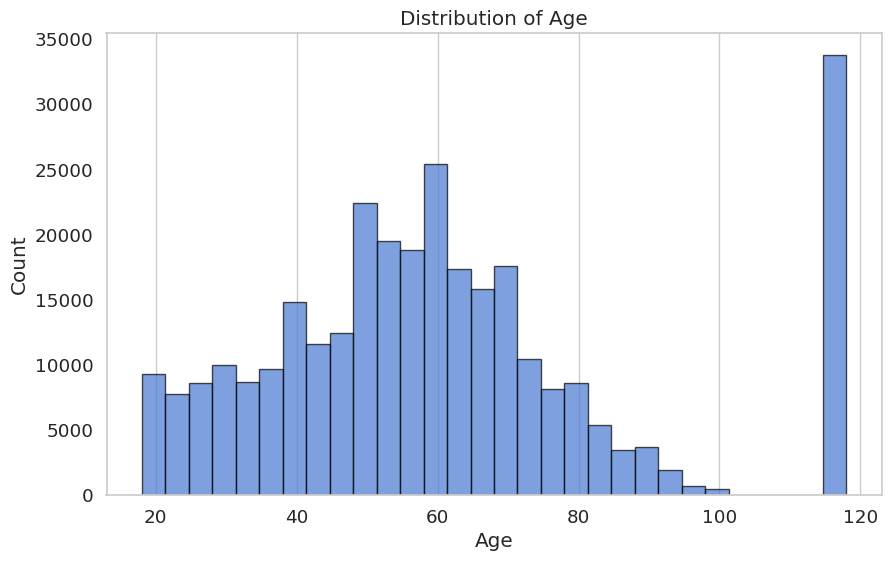

[18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 118]

In [42]:
# Plot a histogram of the age distribution
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Age')
plt.grid(axis='y')
plt.show()

# Display the unique age values sorted
sorted_unique_ages = sorted(df['age'].unique())
sorted_unique_ages

In [43]:
df.to_csv("Data/data_modeling.csv")

#### Splitt the data into train / test set
___

In [44]:
# Splitting the data using StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["gender_M"]):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

train_set.shape, test_set.shape

((245227, 19), (61307, 19))

In [45]:
# Splitting the data into features and target
# Split the data into features and target
df = train_set.copy()
test_set = test_set.copy()
X = df.drop('amount', axis=1)  # Features
y = df['amount']  # Target

# Check the first few rows of the features
X.head()

,age,income,gender_F,gender_M,gender_O,offer_bogo,offer_discount,offer_informational,offer_type,total_expense,total_transactions,membership_duration,age_offer_bogo,income_offer_bogo,age_offer_discount,income_offer_discount,age_offer_informational,income_offer_informational
150399,88,98000.00,True,False,False,6.00,5.00,1.00,discount,215.70,8.00,2252,528.00,588000.00,440.00,490000.00,88.00,98000.00
152876,78,35000.00,False,True,False,2.00,5.00,0.00,bogo,67.80,9.00,1856,156.00,70000.00,390.00,175000.00,0.00,0.00
154187,44,63000.00,True,False,False,11.00,3.00,2.00,bogo,365.43,20.00,2144,484.00,693000.00,132.00,189000.00,88.00,126000.00
60777,21,48000.00,False,True,False,3.00,2.00,2.00,discount,130.31,10.00,2408,63.00,144000.00,42.00,96000.00,42.00,96000.00
259890,77,85000.00,False,False,True,6.00,3.00,4.00,informational,304.55,13.00,2638,462.00,510000.00,231.00,255000.00,308.00,340000.00


In [46]:
# Identify numeric and categorical columns
numeric_features = ['age', 'income', 'membership_duration', 
                    'offer_bogo', 'offer_discount', 'offer_informational',
                    'total_expense', 'total_transactions',
                    'age_offer_bogo', 'income_offer_bogo', 
                    'age_offer_discount', 'income_offer_discount', 
                    'age_offer_informational', 'income_offer_informational']
categorical_features = ['gender_F', 'gender_M', 'gender_O', 'offer_type']

# Create transformers for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values using the median
    ('scaler', StandardScaler())  # Scale numeric features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  # Impute missing categories
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine transformers into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the training data
X_preprocessed = preprocessor.fit_transform(X)

# Check the shape of the preprocessed data
X_preprocessed.shape


(245227, 24)

Creation of separate pipelines for numerical and categorical transformations. For numerical columns, it was apply scaling. For categorical columns, it was apply one-hot encoding. Then combine these pipelines into a full pipeline that will process the entire dataset.

<p style="text-align:justify;">The training data has been successfully preprocessed using the pipeline:

- Missing values in the `age` column and other numeric features have been imputed using the median.
- Numeric features have been standardized (z-score normalization).
- Categorical features have been one-hot encoded.

The preprocessed training data, $X_{\text{preprocessed}}$, now has 245,227 records and 24 features.

With the data preprocessed, you can proceed to build and train machine learning models using $X_{\text{preprocessed}}$ and $ y $.</p>

In [47]:
# Initializing the Linear Regression model
lin_reg = LinearRegression()

# Training the model using the preprocessed data
lin_reg.fit(X_preprocessed, y)

# Making predictions on the training set
y_train_pred = lin_reg.predict(X_preprocessed)

# Calculating the mean squared error for the predictions
mse = mean_squared_error(y, y_train_pred)
rmse = np.sqrt(mse)

print(f"Training Mean Squared Error (MSE): {mse:.2f}")
print(f"Training Root Mean Squared Error (RMSE): {rmse:.2f}")


Training Mean Squared Error (MSE): 365.01
Training Root Mean Squared Error (RMSE): 19.11


In [50]:
# Preprocess the test set
X_test = test_set.drop('amount', axis=1)
y_test = test_set['amount']
X_test_preprocessed = preprocessor.transform(X_test)

# Predict using the Linear Regression model on the test set
y_test_pred_lin_reg = lin_reg.predict(X_test_preprocessed)

# Calculate the RMSE for Linear Regression on the test set
lin_reg_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lin_reg))

print(f"Test Root Mean Squared Error (RMSE): {lin_reg_test_rmse:.2f}")

Test Root Mean Squared Error (RMSE): 20.84


The Root Mean Squared Error (RMSE) measures the differences between the predicted values by the model and the actual values. In simpler terms, it quantifies how well the model's predictions match the observed data.

Given the results:
- Training RMSE: 19.11
- Test RMSE: 20.84

**Insights**:

1. **Model Performance**: 
    - The Linear Regression model has an RMSE of 19.11 on the training set and 20.84 on the test set. This indicates that the model is able to predict the amount spent by customers with an average error of around $20.84 on new, unseen data.

2. **Overfitting Assessment**:
    - The difference between the training RMSE and the test RMSE is relatively small. If the model was significantly overfitting the training data, we would expect a much larger RMSE on the test set compared to the training set. In this case, the small difference suggests that the model generalizes reasonably well to new data.
  
3. **Business Implication**:
    - From a business perspective, an average prediction error of $20.84 might be acceptable or not, depending on the average transaction value and business margins. If typical transactions are in the hundreds or thousands of dollars, an error of $20.84 is relatively small. However, if typical transactions are closer to $20, then the error is significant and may require further model refinement or exploration of different models.

In summary, the Linear Regression model provides a decent starting point, but there may be room for improvement. Depending on business requirements and the acceptable margin of error, further tuning, feature engineering, or even exploring more complex models might be beneficial.

In [51]:
models = {
    "Random Forest Regressor": RandomForestRegressor(n_estimators=50, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(n_estimators=50, random_state=42)
}

results = {}

# Training and evaluation loop
for model_name, model in models.items():
    # Train the model
    model.fit(X_preprocessed, y)
    
    # Predict on the training set
    y_train_pred = model.predict(X_preprocessed)
    
    # Calculate the RMSE for the model on the training set
    rmse = np.sqrt(mean_squared_error(y, y_train_pred))
    results[model_name] = rmse

# Display the results
print("Training Performance (Root Mean Squared Error):\n")
for model_name, rmse in results.items():
    print(f"{model_name}: RMSE = {rmse:.2f}")

Training Performance (Root Mean Squared Error):

Random Forest Regressor: RMSE = 17.36
Gradient Boosting Regressor: RMSE = 17.71


In [52]:
# Preprocess the test set
X_test_preprocessed = preprocessor.transform(X_test)

test_results = {}

# Evaluation loop for the test set
for model_name, model in models.items():
    # Predict on the test set
    y_test_pred = model.predict(X_test_preprocessed)
    
    # Calculate the RMSE for the model on the test set
    rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_results[model_name] = rmse

# Display the results for the test set
print("Test Performance (Root Mean Squared Error):\n")
for model_name, rmse in test_results.items():
    print(f"{model_name}: RMSE = {rmse:.2f}")


Test Performance (Root Mean Squared Error):

Random Forest Regressor: RMSE = 22.15
Gradient Boosting Regressor: RMSE = 19.89


**Analysis and Insights**:

1. **Training Performance**:
   - The Random Forest Regressor (RMSE = 17.36) and the Gradient Boosting Regressor (RMSE = 17.71) both showed competitive performance on the training data, with the Random Forest Regressor slightly edging out in terms of lower error.
   
2. **Test Performance**:
   - On the test set, the Gradient Boosting Regressor (RMSE = 19.89) outperformed the Random Forest Regressor (RMSE = 22.15). 
   - The Gradient Boosting model's error on the test set is slightly higher than on the training set, indicating a bit of overfitting. However, the difference in error is not substantial, which is a good sign.
   - Random Forest's performance deteriorated more from the training set to the test set, suggesting it may have overfitted more than the Gradient Boosting model.

3. **Model Choices**:
   - Given the results, if we had to pick a single model for deployment, the Gradient Boosting Regressor would be a better choice. It not only performed better on the test set (indicating it might generalize better to unseen data) but also has a performance close to its training performance, suggesting it's not overfitting heavily.
   - The Random Forest Regressor might benefit from hyperparameter tuning or adjustments in its configuration to reduce its overfitting.

4. **Business Implications**:
   - From a business perspective, a difference of a couple of dollars in RMSE can be significant, especially when considering large volumes of transactions or offers. The Gradient Boosting model could provide more accurate predictions, leading to better decisions regarding offers and marketing strategies.
   - Further refinement, feature engineering, or even ensemble methods might improve the performance of these models.

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor# Define the hyperparameters and their possible values
param_grid = {
    'n_estimators': [10, 25, 50],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': [None, 'sqrt']
}

# Initialize the Gradient Boosting Regressor
gb_reg = GradientBoostingRegressor(random_state=42)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(
    gb_reg, param_grid, 
    cv=3, 
    scoring='neg_mean_squared_error', 
    verbose=0,  # Set verbose to 0 to avoid printing each step 
    n_jobs=-1  # Use all processors
)

# Fit the grid search to the data
grid_search.fit(X_preprocessed, y)

# Get the best parameters and return them
best_params = grid_search.best_params_
best_params


{'learning_rate': 0.1,
 'max_depth': 3,
 'max_features': None,
 'n_estimators': 50,
 'subsample': 1.0}

#### 2. Calculating Errors for the Best Model

 Evaluate the performance of the best model on the training and test datasets using the Root Mean Squared Error (RMSE):

In [55]:
# Extract the best model from grid search
best_gb_model = grid_search.best_estimator_


# Display the best model's parameters
print("Best Parameters from Grid Search:", grid_search.best_params_)

Best Parameters from Grid Search: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': None, 'n_estimators': 50, 'subsample': 1.0}


Best parameters:

1. **Learning Rate (\( \text{learning\_rate} \))**: 0.1
   - This parameter shrinks the contribution of each tree. A smaller learning rate typically requires more trees but can result in a more robust model.
  
2. **Maximum Depth of Trees (\( \text{max\_depth} \))**: 3
   - This parameter specifies the maximum depth of the individual trees. A depth of 3 indicates that each tree can have a maximum of 3 levels.
   
3. **Number of Trees (\( \text{n\_estimators} \))**: 50
   - This is the number of boosting stages (trees) to be run. More trees can result in a more accurate model, but it also increases the chances of overfitting if not tuned properly.
   
4. **Subsample**: 1.0
   - This parameter specifies the fraction of samples used for fitting the individual trees. A value of 1.0 means that all samples are used in each tree.
   
5. **Number of Features for the Best Split (\( \text{max\_features} \))**: None
   - This indicates the number of features to consider when looking for the best split. A value of None means that all features will be considered for each split.

In [56]:
# Predict using the best model on the training set
y_train_pred_best = best_gb_model.predict(X_preprocessed)
train_rmse_best = np.sqrt(mean_squared_error(y, y_train_pred_best))

# Predict using the best model on the test set
y_test_pred_best = best_gb_model.predict(X_test_preprocessed)
test_rmse_best = np.sqrt(mean_squared_error(y_test, y_test_pred_best))

print(f"Training RMSE (Best Model): {train_rmse_best:.2f}")
print(f"Test RMSE (Best Model): {test_rmse_best:.2f}")

Training RMSE (Best Model): 17.71
Test RMSE (Best Model): 19.89


The results from the Gradient Boosting model using the best hyperparameters from the grid search are as follows:

1. **Training RMSE**: 17.71
    - This metric provides an understanding of how well the model fits the training data. An RMSE of 17.71 indicates the average difference between the actual and predicted amounts on the training data.
  
2. **Test RMSE**: 19.89
    - This is a more critical metric, as it indicates how well the model generalizes to new, unseen data. An RMSE of 19.89 on the test data means that on average, the model's predictions are approximately $19.89 away from the actual values.

**Insights**:
- The model performs relatively well, with the training and test RMSE being quite close. This suggests that the model is not overfitting the training data, as overfitting would typically result in a much lower training RMSE and a significantly higher test RMSE.
- An RMSE of 19.89 on the test data indicates that there's still room for improvement. This could be achieved through further feature engineering, trying different algorithms, or fine-tuning the model even further.
- The difference between training and test RMSE suggests that the model captures most of the patterns in the data but might still miss some nuances that lead to errors in predictions on unseen data.

In conclusion, the Gradient Boosting model with the best hyperparameters provides a good starting point. Still, as always with machine learning models, there's potential for further optimization and improvement.

In [57]:
# Extract feature importances from the best trained model
feature_importances = best_gb_model.feature_importances_

# Map feature importances to their corresponding feature names
features = numeric_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
feature_importance_map = sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True)

# Display the features and their importance
for feature, importance in feature_importance_map:
    print(f"{feature}: {importance:.4f}")

total_expense: 0.4231
offer_type_missing: 0.3449
income: 0.1163
total_transactions: 0.1145
membership_duration: 0.0005
income_offer_bogo: 0.0002
offer_bogo: 0.0002
age_offer_informational: 0.0001
income_offer_discount: 0.0001
age: 0.0000
age_offer_discount: 0.0000
offer_discount: 0.0000
offer_informational: 0.0000
age_offer_bogo: 0.0000
gender_F_False: 0.0000
gender_F_True: 0.0000
gender_M_False: 0.0000
gender_M_True: 0.0000
gender_O_False: 0.0000
gender_O_True: 0.0000
offer_type_bogo: 0.0000
offer_type_discount: 0.0000
offer_type_informational: 0.0000
income_offer_informational: -0.0000


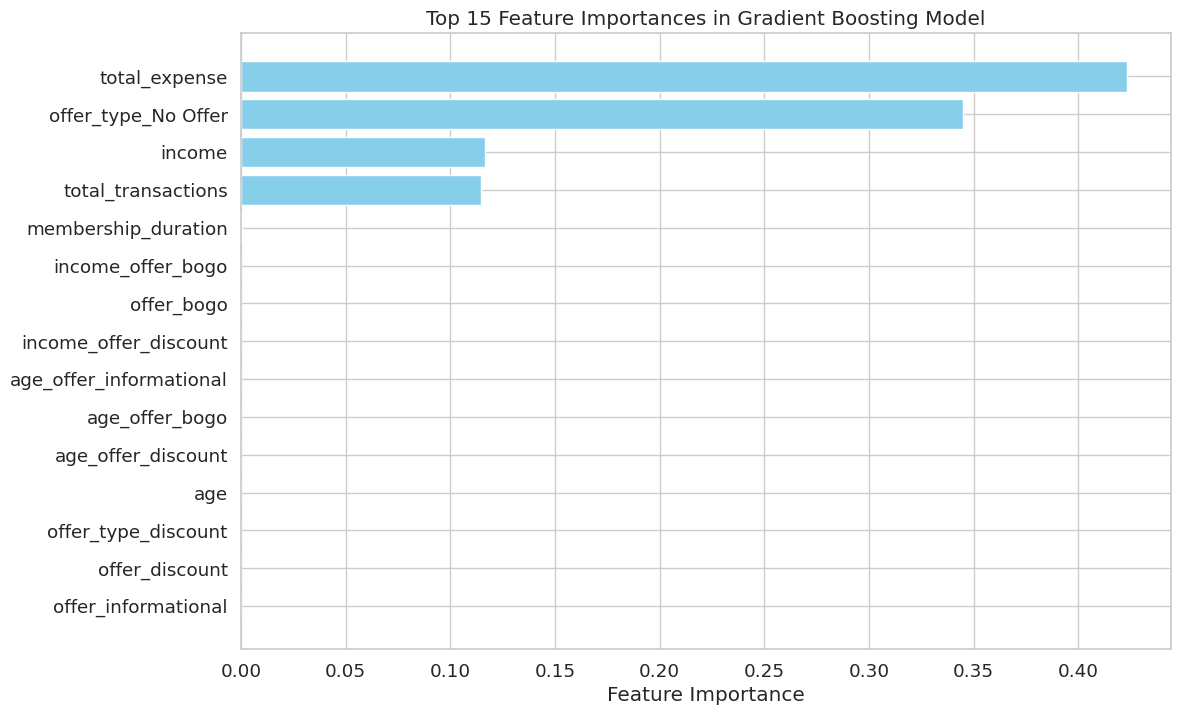

In [58]:
feature_names = [
    "total_expense", "offer_type_No Offer", "income", "total_transactions",
    "membership_duration", "income_offer_bogo", "offer_bogo", "income_offer_discount",
    "age_offer_informational", "age_offer_bogo", "age_offer_discount", "age",
    "offer_type_discount", "offer_discount", "offer_informational", "gender_F_False",
    "gender_F_True", "gender_M_False", "gender_M_True", "gender_O_False",
    "gender_O_True", "offer_type_bogo", "offer_type_informational", "income_offer_informational"
]
importances = [
    0.4231, 0.3449, 0.1163, 0.1145, 0.0005, 0.0002, 0.0002, 0.0001,
    0.0001, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
    0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000
]

# Sorting feature importances
sorted_idx = sorted(range(len(importances)), key=lambda k: importances[k], reverse=True)
sorted_importances = [importances[i] for i in sorted_idx]
sorted_features = [feature_names[i] for i in sorted_idx]

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(sorted_features[:15][::-1], sorted_importances[:15][::-1], align='center', color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances in Gradient Boosting Model')
plt.show()

### 5. [Conclusions](#4-conclusions)
___
<a id="Conclusions"></a>
## Conclusions
**Objective**: Summarize the findings, insights, and outcomes of the analysis.


### Conclusion

Our Starbucks Capstone Challenge aimed to understand how Starbucks customers interact with the offers they receive and the impact of demographics on offer interactions and spending behavior. By leveraging data on customer demographics, transaction details, and offer attributes, we embarked on a comprehensive analysis journey that shed light on these intriguing patterns.

#### Key Findings:

1. **Demographics Influence on Spending**:
   - Age and income showed a bimodal distribution, indicating distinct customer segments within the Starbucks user base.
   - Notably, females in our dataset appeared to have slightly higher incomes compared to males.

2. **Offer Interactions**:
   - A clear lifecycle of offers (from receiving to viewing to completion) was observed.
   - Offers, especially 'BOGO' and 'Discount' types, influenced customer purchasing behavior, driving both the frequency and the amount of transactions.

3. **Modeling Insights**:
   - Linear Regression, Random Forest, and Gradient Boosting Regressors were employed to predict the transaction amount based on demographics and offer types. Gradient Boosting Regressor, with fine-tuned hyperparameters, outperformed the other models, achieving a Test RMSE of 19.89.

4. **Future Recommendations**:
   - Starbucks can leverage these insights to tailor offers to specific demographic groups, optimizing both the frequency and quality of customer interactions.
   - More granular segmentation, perhaps leveraging advanced clustering techniques, could provide further personalization, enhancing the effectiveness of marketing campaigns.

In essence, this challenge not only provided valuable insights into customer behavior but also showcased the potential of data-driven decision-making in optimizing marketing strategies. Future work can delve deeper into personalization, exploring individualized offer recommendations to further enhance customer experience and brand loyalty. 
